In [27]:
# https://zenodo.org/records/4670277
#
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import nibabel as nib
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
import os
import matplotlib.gridspec as gridspec
from numpy.linalg import pinv

from Tools.fmri_tools import *
from Tools.model_info_tools import *
from Tools.mathematical_tools import *

from Encoder import*
from scipy.stats import zscore
import torch.optim as optim
from torch.utils.data import DataLoader,random_split



### Embedding parameters and Datasets

In [ ]:
image_name = 'rs-fmri-'
input_folder = 'Compressed Data'

# Indexes of the desired trials
index = [2,3,4]
model_name = 'Example'

embedding_dim = 20
tau = 2
r = 15
n_components = 3
lag_path = os.path.join('..', 'best_lags.npy')
corr_path = os.path.join('..', 'best_corrs.npy')
lag_list = np.load(lag_path)
corr_list = np.load(corr_path)

print('lag shape:', lag_list.shape)
print('corr shape:', corr_list.shape)

indices = np.array(index) - 1
lag_list = lag_list[indices]
corr_list = corr_list[indices]

min_corr = 0.5
max_lag = 30

pupil_name = 'pupil_diameter_74_trials.npy'
pupil_name = os.path.join('..', pupil_name)
pupil = np.load(pupil_name)

pupil = pupil[indices, :]

selected_pupil = []

def load_datasets(image_name, input_folder, index_list, threshold=0.5, max_lag=10):
    dataset_list = []
    voxel_list = []
    for idx in index_list:
       
        if (abs(corr_list[np.where(indices== (idx-1))[0][0]]) > threshold) and (abs(lag_list[np.where(indices== (idx-1))[0][0]]) < max_lag):
            file_name = f"{image_name}{idx}.npz"
            file_path = os.path.join('..', input_folder, file_name)
            selected_pupil.append(pupil[np.where(indices==(idx-1))[0][0], :])
            try:
                data = np.load(file_path)
                sliced_data_res = data['functional_data_res']
                active_voxel_indices = data['active_voxel_indices']
                dataset_list.append(sliced_data_res)
                voxel_list.append(active_voxel_indices)
                print(f"Caricato: {file_name} con shape {sliced_data_res.shape} e correlazione: {corr_list[np.where(indices==(idx-1))[0][0]]} e lag: {lag_list[np.where(indices==(idx-1))[0][0]]}")
            except Exception as e:
                print(f"Errore nel caricamento di {file_name}: {e}")
        else:
            print(f"Saltato: {image_name}{idx}.npz perché corr_list[{idx-1}] = {corr_list[np.where(indices==(idx-1))[0][0]]} non supera la soglia {threshold}")
    if dataset_list:
        dataset_array = np.stack(dataset_list, axis=0)
        voxel_array = np.stack(voxel_list)
    else:
        dataset_array = None
    return dataset_array, voxel_array

# Load the datasets
decoder_dataset, active_voxels_indices = load_datasets(image_name, input_folder, index, threshold=min_corr, max_lag = max_lag)
active_voxels = decoder_dataset.shape[1]


pupil = np.array(selected_pupil)
range_set = pupil.shape[0]

print(f"Shape finale del dataset: {decoder_dataset.shape}")
print(f"Shape finale del dataset pupil: {pupil.shape}")

# Isolating frequencies from data:
# Filtering the signal
fmin = 0.01
fmax = 0.05

pupil_filtered = filter_pupil_signal(pupil, fmin, fmax)
print('pupil_filtered shape:', pupil_filtered.shape)


lag shape: (73,)
corr shape: (73,)
Caricato: rs-fmri-2.npz con shape (21680, 925) e correlazione: -0.6455383874964343 e lag: 13
Caricato: rs-fmri-3.npz con shape (21680, 925) e correlazione: -0.7350390751899801 e lag: 15
Caricato: rs-fmri-4.npz con shape (21680, 925) e correlazione: -0.7865553100001432 e lag: 12
Shape finale del dataset: (3, 21680, 925)
Shape finale del dataset pupil: (3, 925)
pupil_filtered shape: (3, 925)


### fmri's PCs

In [ ]:
# Initializing the lists to store the results
PC_dataset = []
PCA_transformation = []
norm_params = []  
var_explained = []

for i in range(range_set):
    # PCA for trial i
    pca = PCA(n_components=n_components)
    y = pca.fit_transform(decoder_dataset[i].T)
    
    # Apply bandpass filter to the data
    b, a = butter(4, [fmin, fmax], 'bandpass')
    y_filtered = filtfilt(b, a, y, padlen=10, axis=0)
    
    norm_params_set = []
    
    # Normalize each component (zscore) saving mean and std to invert the normalization
    for j in range(n_components):
        mu = np.mean(y_filtered[:, j])
        std = np.std(y_filtered[:, j])
        norm_params_set.append((mu, std))
        y_filtered[:, j] = (y_filtered[:, j] - mu) / std  # Normalizzazione z-score
        
    norm_params.append(norm_params_set)
    
    # Storing the PCA object is useful for later inverse transformation
    PC_dataset.append(y_filtered.T)
    PCA_transformation.append(pca)
    
    # Evaluate the explained variance
    explained_variance = pca.explained_variance_ratio_
    cumul_explained = np.cumsum(explained_variance)
    var_explained.append(cumul_explained)
    print(f'Set {i+1} - Varianza spiegata cumulativa: {cumul_explained}')

PC_dataset = np.array(PC_dataset)
var_explained = np.array(var_explained)

tau_crit = np.zeros((range_set, n_components))
for i in range(range_set):
    for j in range(n_components):
        _, _, time_window = compute_tau_critical(PC_dataset[i, j, :], dt=1.0)
        tau_crit[i, j] = time_window
        print('tau_crit:', time_window)
    # Correlation coefficient
    corr_pc1_pupil = np.corrcoef(PC_dataset[i, 0, :], pupil_filtered[i, :])[0, 1]
    print(f'Dataset {i+1} - Correlazione tra PC1 e pupil: {corr_pc1_pupil}')

print('Actual time window: ', (embedding_dim-1)*tau)
print('PC dataset shape:', PC_dataset.shape)


for i in range(range_set):
    _,_,time_window = compute_tau_critical(pupil_filtered[i,:], dt=1.0)
    print('tau_crit pupil:', time_window)

Set 1 - Varianza spiegata cumulativa: [0.5115651  0.57653546 0.6224482 ]
Set 2 - Varianza spiegata cumulativa: [0.50946933 0.5692591  0.61940193]
Set 3 - Varianza spiegata cumulativa: [0.4681305 0.5291144 0.578283 ]
tau_crit: 41.5759660915191
tau_crit: 34.9157314009157
tau_crit: 35.88170792363282
Dataset 1 - Correlazione tra PC1 e pupil: -0.3459947930190529
tau_crit: 42.36310617486972
tau_crit: 42.64795725235805
tau_crit: 35.64696764691843
Dataset 2 - Correlazione tra PC1 e pupil: -0.33340658579072857
tau_crit: 38.780646077363365
tau_crit: 38.709402888841254
tau_crit: 36.907362972081806
Dataset 3 - Correlazione tra PC1 e pupil: -0.3738364688242989
Actual time window:  38
PC dataset shape: (3, 3, 925)
tau_crit pupil: 47.43437232283478
tau_crit pupil: 43.82667226217678
tau_crit pupil: 42.237786073879136


### Lag correction

In [ ]:
# Evaluate the maximum lag values
print('Lag_list shape:', lag_list.shape)
print('Corr_list shape:', corr_list.shape)

L_max_pos = max([lag for lag in lag_list if lag > 0] or [0])
L_max_neg = max([-lag for lag in lag_list if lag < 0] or [0])

print('L_max_pos:', L_max_pos)
print('L_max_neg:', L_max_neg)

final_shape = 925 - (L_max_pos - L_max_neg)  # final shape after shifting
print('Final shape:', final_shape)

# Create dummy arrays to store shifted data
pupil_dummy = np.zeros((range_set, final_shape))
PC_dummy = np.zeros((range_set, n_components, final_shape))
decoder_dummy = np.zeros((range_set, active_voxels, final_shape))

correlation_list = []

for i in range(range_set):
    if lag_list[i] < 0:
        shifted_p = pupil_filtered[i, :lag_list[i]]
        shifted_pc = PC_dataset[i, :, -lag_list[i]:]
    if lag_list[i] >= 0:
        shifted_p = pupil_filtered[i, lag_list[i]:]
        shifted_pc = PC_dataset[i, :, :len(pupil_filtered[i, lag_list[i]:])]
        
    if len(shifted_p) > 1 and len(shifted_p) == shifted_pc.shape[1]:
        corr = np.corrcoef(shifted_p, shifted_pc[0, :])[0, 1]
        print(f'Correlazione tra pupil e PC1 con lag: {lag_list[i]}: {corr}')
    
    # Cutting the data to match the length of the lag
    max_dif = abs(lag_list[i] - L_max_pos)
    min_dif = abs(lag_list[i] - L_max_neg)
    
    if lag_list[i] > 0:  # if lag > 0, remove the first max_dif samples
        shifted_p = shifted_p[max_dif:]
        shifted_pc = shifted_pc[:, max_dif:]
    if lag_list[i] < 0:  # if lag < 0, remove the last min_dif samples
        shifted_p = shifted_p[:-min_dif]
        shifted_pc = shifted_pc[:, :-min_dif]
        
    if len(shifted_p) > 1 and len(shifted_p) == shifted_pc.shape[1]:
        corr = np.corrcoef(shifted_p, shifted_pc[0, :])[0, 1]
        correlation_list.append(corr)
        print(f'Correlazione tra pupil e PC1 dopo rimozione: {lag_list[i]}: {corr}')
        
    pupil_dummy[i] = shifted_p
    PC_dummy[i] = shifted_pc

    # Now shift decoder_dataset with the same logic
    # If the lag is positive,take from the lag onwards.
    # If the lag is negative, take from the beginning to the lag.
    if lag_list[i] < 0:
        shifted_dec = decoder_dataset[i, :, :lag_list[i]]
    if lag_list[i] >= 0:
        shifted_dec = decoder_dataset[i, :, lag_list[i]:]
    

    if lag_list[i] > 0:
        shifted_dec = shifted_dec[:, max_dif:]
    if lag_list[i] < 0:
        shifted_dec = shifted_dec[:, :-min_dif]
    
    decoder_dummy[i] = shifted_dec

PC_dataset = PC_dummy
pupil_filtered = pupil_dummy
decoder_dataset = decoder_dummy

print('PC dataset shape:', PC_dataset.shape)
print('Pupil shape:', pupil_filtered.shape)
print('Decoder dataset shape:', decoder_dataset.shape)

Lag_list shape: (3,)
Corr_list shape: (3,)
L_max_pos: 15
L_max_neg: 0
Final shape: 910
Correlazione tra pupil e PC1 con lag: 13: -0.6455378048375103
Correlazione tra pupil e PC1 dopo rimozione: 13: -0.6456629180022918
Correlazione tra pupil e PC1 con lag: 15: -0.7350390777946766
Correlazione tra pupil e PC1 dopo rimozione: 15: -0.7350390777946766
Correlazione tra pupil e PC1 con lag: 12: -0.7865553740695325
Correlazione tra pupil e PC1 dopo rimozione: 12: -0.7859101806517601
PC dataset shape: (3, 3, 910)
Pupil shape: (3, 910)
Decoder dataset shape: (3, 21680, 910)


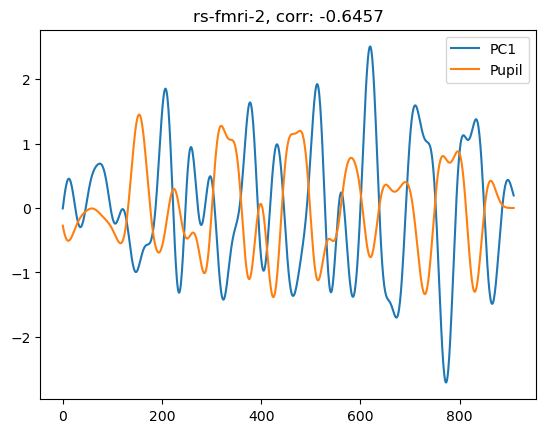

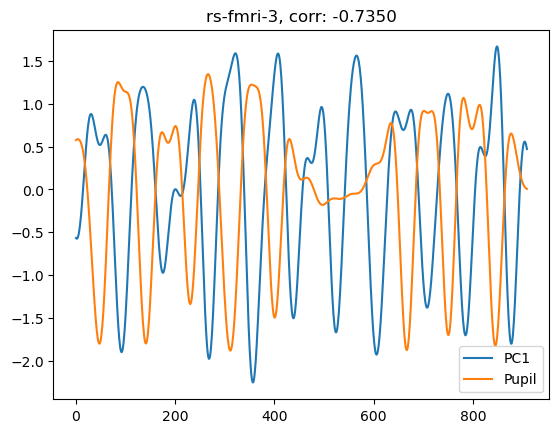

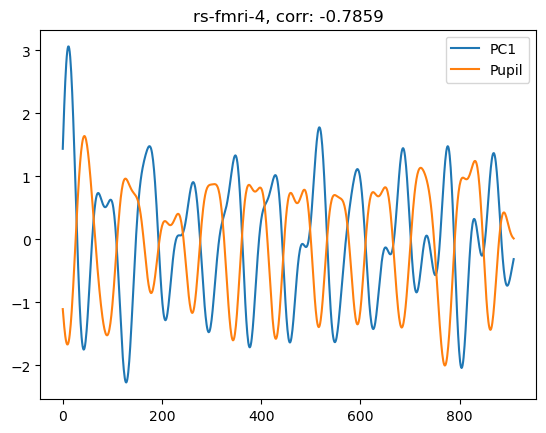

In [31]:
correlation_list = np.array(correlation_list)
for i in range(range_set):
        plt.plot(PC_dataset[i,0,:], label = 'PC1')
        plt.plot(pupil_filtered[i,:], label = 'Pupil')
        plt.title(f'rs-fmri-{index[i]}, corr: {correlation_list[i]:.4f}')
        plt.legend()
        plt.show()

### Pupil Embeddings

In [ ]:
#Embeddding preparation
hankel_matrix = []
projected_hankel_matrix = []

pupil_filtered = zscore(pupil_filtered, axis=-1)
for i in range(range_set):
    hankel_matrix.append(create_time_delay_embedding(data=pupil_filtered[i,:], delay=tau,embedding_dim=embedding_dim).T)

hankel_matrix = np.array(hankel_matrix)
print('Hankel matrix shape:', hankel_matrix.shape)

P = legendre_basis(embedding_dim,r)
print('Legendre basis Matrix shape:', P.shape)

for i in range(range_set):
    projected_hankel_matrix.append(np.dot(hankel_matrix[i].T,P).T)

projected_hankel_matrix = np.array(projected_hankel_matrix)
print('Projected Hankel matrix shape:', projected_hankel_matrix.shape)

#Extracting training data, validation data and test data

total_size = int(projected_hankel_matrix.shape[2])
train_index = int(0.70 * total_size)  # training
val_index = int( train_index + 0.15 * total_size)    # validation
test_index = int(val_index + 0.15 * total_size)   # test
print('Indexes:', train_index, val_index, test_index)

train_matrix = projected_hankel_matrix[:,:,0:(train_index)]
val_matrix = projected_hankel_matrix[:,:,train_index:(val_index)]
test_matrix = projected_hankel_matrix[:,:,val_index:(test_index)]

train_time_start = 0
train_time_end = (train_index-1) + (embedding_dim-1)*tau
val_time_start = train_index 
val_time_end = (val_index-1) + (embedding_dim-1)*tau
test_time_start = val_index
test_time_end = (test_index-1) + (embedding_dim-1)*tau


print('########################################')
print('TIME STEP FOR SERIES:')
print('Train i-f:', train_time_start,' - ',train_time_end)
print('Val i-f:', val_time_start,' - ',val_time_end)
print('Test i-f:', test_time_start,' - ',test_time_end)
print('########################################')


legendre_test_matrix_norm = test_matrix

print('Original Matrix shape (range_set,r,n_sample):')
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)

# Transposing the matrices to allign time series
train_matrix = np.transpose(train_matrix, (1, 0, 2))
val_matrix = np.transpose(val_matrix, (1, 0, 2))
test_matrix = np.transpose(test_matrix, (1, 0, 2))

print('Transposed Matrix shape (r,range_set,n_samples):')
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)

train_matrix = train_matrix.reshape(r, -1)
val_matrix = val_matrix.reshape(r, -1)
test_matrix = test_matrix.reshape(r, -1)

print('Flattened Matrix shape (r, range_set*num_samples):') 
print('Train:', train_matrix.shape)
print('Val:', val_matrix.shape)
print('Test:', test_matrix.shape)


Hankel matrix shape: (3, 20, 872)
Legendre basis Matrix shape: (20, 15)
Projected Hankel matrix shape: (3, 15, 872)
Indexes: 610 740 870
########################################
TIME STEP FOR SERIES:
Train i-f: 0  -  647
Val i-f: 610  -  777
Test i-f: 740  -  907
########################################
Original Matrix shape (range_set,r,n_sample):
Train: (3, 15, 610)
Val: (3, 15, 130)
Test: (3, 15, 130)
Transposed Matrix shape (r,range_set,n_samples):
Train: (15, 3, 610)
Val: (15, 3, 130)
Test: (15, 3, 130)
Flattened Matrix shape (r, range_set*num_samples):
Train: (15, 1830)
Val: (15, 390)
Test: (15, 390)


### fmri Embeddings

In [ ]:
fmri_embedding_pc = []
fmri_embedding_set = []
fmri_projected_pc = []
fmri_projected_set = []

# Embedding preparation
for i in range(range_set): # 0 2
    for j in range(n_components): # 0 5
        fmri_embedding_pc.append(create_time_delay_embedding(data=PC_dataset[i,j,:], delay=tau,embedding_dim=embedding_dim).T)
    
    fmri_embedding_set.append(np.array(fmri_embedding_pc))
    fmri_embedding_pc = []

fmri_embedding_set = np.array(fmri_embedding_set)
print('Fmri embedding shape (set, n_components, embedding_dim, n_samples):', fmri_embedding_set.shape)


embedded_train_matrix = fmri_embedding_set[:,:,:,0:(train_index)]
embedded_val_matrix = fmri_embedding_set[:,:,:,train_index:(val_index)]
embedded_test_matrix = fmri_embedding_set[:,:,:,val_index:(test_index)]

# Projecting the Hankel matrix for every components

for i in range(range_set):
    for j in range(n_components):
        fmri_projected_pc.append(np.dot(fmri_embedding_set[i,j].T,P).T)
    
    fmri_projected_set.append(np.array(fmri_projected_pc))
    fmri_projected_pc = []


fmri_projected_set = np.array(fmri_projected_set)
print('Fmri projected shape (set, n_components, r, n_samples):', fmri_projected_set.shape)

# Creation of training, validation and test set
train_fmri = fmri_projected_set[:,:,:,0:(train_index)]
val_fmri = fmri_projected_set[:,:,:,train_index:(val_index)]
test_fmri = fmri_projected_set[:,:,:,val_index:(test_index)]

print('Original Matrix shape (range_set,n_components,r,n_sample):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

# Transposing the matrices to allign time series (n_components,r,range_set,n_samples) -> (1,2,0,3)

train_fmri = np.transpose(train_fmri, (1, 2, 0, 3))
val_fmri = np.transpose(val_fmri, (1, 2, 0, 3))
test_fmri = np.transpose(test_fmri, (1, 2, 0, 3))

print('Transposed Matrix shape (n_components,r,range_set,n_samples):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

# Flattening the matrices along samples and range (n_components,r,range_set*num_samples)

train_fmri = train_fmri.reshape(n_components, r, -1)
val_fmri = val_fmri.reshape(n_components, r, -1)
test_fmri = test_fmri.reshape(n_components, r, -1)

print('Flattened Matrix shape (n_components,r,range_set*num_samples):')
print('Train fmri shape:', train_fmri.shape)
print('Val fmri shape:', val_fmri.shape)
print('Test fmri shape:', test_fmri.shape)

Fmri embedding shape (set, n_components, embedding_dim, n_samples): (3, 3, 20, 872)
Fmri projected shape (set, n_components, r, n_samples): (3, 3, 15, 872)
Original Matrix shape (range_set,n_components,r,n_sample):
Train fmri shape: (3, 3, 15, 610)
Val fmri shape: (3, 3, 15, 130)
Test fmri shape: (3, 3, 15, 130)
Transposed Matrix shape (n_components,r,range_set,n_samples):
Train fmri shape: (3, 15, 3, 610)
Val fmri shape: (3, 15, 3, 130)
Test fmri shape: (3, 15, 3, 130)
Flattened Matrix shape (n_components,r,range_set*num_samples):
Train fmri shape: (3, 15, 1830)
Val fmri shape: (3, 15, 390)
Test fmri shape: (3, 15, 390)


### VAE settings

In [ ]:
output_dim = r*n_components

latent_dim = 10
encoder_layers = [r, latent_dim]  
decoder_layers = [latent_dim,output_dim] 

# Database path
model_database_path = os.path.join('..','Def_list.json')

# Loading all available configuration
all_configs = load_configs(model_database_path)
epochs = 1000

# Current configuration
decoder_config = {
    "model_name": model_name,
    "index": index,
    "min_corr": min_corr,
    "max_lag": max_lag,
    "decoder_layers": decoder_layers,
    "encoder_layers": encoder_layers,
    "n_components": n_components,
    "latent_dim": latent_dim,
    "embedding_dim": embedding_dim,
    "tau": tau,
    "r": r,
    "epochs": epochs,
    "early_stopping": {"patience": 100000, "delta": -1}, # Early stopping: -1 to turn off
    "beta_method": "sigmoid", #constant, sigmoid, linear, linear_decay, exponential_decay
    "beta_value": 0.1, 
    "kl_annealing_epochs":  500, # warmup epoch
    "decay_start": 50, 
    "decay_epoch": 40, # decay time after start
    "dataset": range_set,
    "batch_size": 32,
    "optimizer": "Adam",
    "learning_rate": 0.0001,
    "scheduler": {
        "type": "None", # None to use a constant learning rate
        "params": {

            # ReduceLROnPlateau
            "mode": "min",      # Monitor minimum 
            "factor": 0.5,      # Reduction factor (LR = LR * factor)
            "patience": 10,     
            "min_lr": 1e-09 ,  # Lower bound

            # CyclicLR
            "base_lr": 0.0001,  # Minimum LR for CyclicLR
            "max_lr": 0.001,     # Maximum LR for CyclicLR
            "step_size_up": 100, 
            # CosineAnnealingLR
            "T_max": 300,       # Numero di step fino al minimo (solo per CosineAnnealingLR)

            # CosineAnnealingWarmRestarts
            "T_0": 100,          # Number of epochs for the first cycle
            "T_mult": 2,         # Moltiplication factor 
            "eta_min": 0.00000001,  # Minimum value for CosineAnnealingLR and CosineAnnealingWarmRestarts
        }
    }
}

In [ ]:
# Crea il dataset
train_dataset = EmbeddedDatasetforDecoder(train_matrix, train_fmri)
val_dataset = EmbeddedDatasetforDecoder(val_matrix, val_fmri)
test_dataset = EmbeddedDatasetforDecoder(test_matrix, test_fmri)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepara il DataLoader
batch_size = decoder_config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debug del batch
for batch in train_loader:
    inputs, targets = batch  # Decomponi input e target
    inputs = inputs.float()
    targets = targets.float()
    print("Shape of input:", inputs.shape) 
    print("Shape of target:", targets.shape) 
    break

Shape of input: torch.Size([32, 15])
Shape of target: torch.Size([32, 3, 15])


In [ ]:
# VAE instance
encoder = Encoder(encoder_layers)
encoder = encoder.to(device)
decoder_layers_reversed = decoder_layers[::-1]
decoder = Decoder(decoder_layers_reversed)
decoder = decoder.to(device)
vae_model = VAE(encoder,decoder)
vae_model = vae_model.to(device)

# Optimizer and Scheduler config

optimizer = optim.Adam(filter(lambda p: p.requires_grad, vae_model.parameters()), lr=decoder_config["learning_rate"])
scheduler_config = decoder_config.get("scheduler")
scheduler = get_scheduler(optimizer, scheduler_config)

### VAE Training:

In [38]:
train_losses, val_losses, recon_losses, kld_losses, effective_kld_losses, beta_values, stopped_epoch, gradient_history, lr_evolution, separate_recon_losses = recon_fmri_pc(
    device=device,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader, 
    r=r,
    n_components=n_components,
    model=vae_model,
    optimizer=optimizer,
    scheduler=scheduler,
    scheduler_config=scheduler_config,
    kl_annealing_epochs=decoder_config["kl_annealing_epochs"],
    decay_epoch=decoder_config["decay_epoch"],
    decay_start=decoder_config["decay_start"],
    beta_method=decoder_config["beta_method"],
    beta_value=decoder_config["beta_value"],
    early_stopping_params=decoder_config["early_stopping"]
)

Epoch [1/1000], Rec Loss: 37.6837, KLD Loss: 133.1412, Beta: 0.0000, KLD*B = 0.0000, Total Loss: 37.6837, lr = 0.000100
Separate Recon Loss per component: [14.102962156201972, 11.420813621979594, 12.159905071988131]
Epoch [2/1000], Rec Loss: 36.8895, KLD Loss: 115.4995, Beta: 0.0000, KLD*B = 0.0000, Total Loss: 36.8895, lr = 0.000100
Separate Recon Loss per component: [13.397998213637722, 11.422547012078958, 12.069001519875448]
Epoch [3/1000], Rec Loss: 33.5319, KLD Loss: 99.5974, Beta: 0.0000, KLD*B = 0.0000, Total Loss: 33.5319, lr = 0.000100
Separate Recon Loss per component: [12.424250868500256, 10.446104939778646, 10.661526480919676]
Epoch [4/1000], Rec Loss: 31.8281, KLD Loss: 87.0287, Beta: 0.0000, KLD*B = 0.0000, Total Loss: 31.8281, lr = 0.000100
Separate Recon Loss per component: [11.712879518602715, 9.993685562884222, 10.121537955862577]
Epoch [5/1000], Rec Loss: 30.4101, KLD Loss: 76.6770, Beta: 0.0000, KLD*B = 0.0000, Total Loss: 30.4101, lr = 0.000100
Separate Recon Loss 

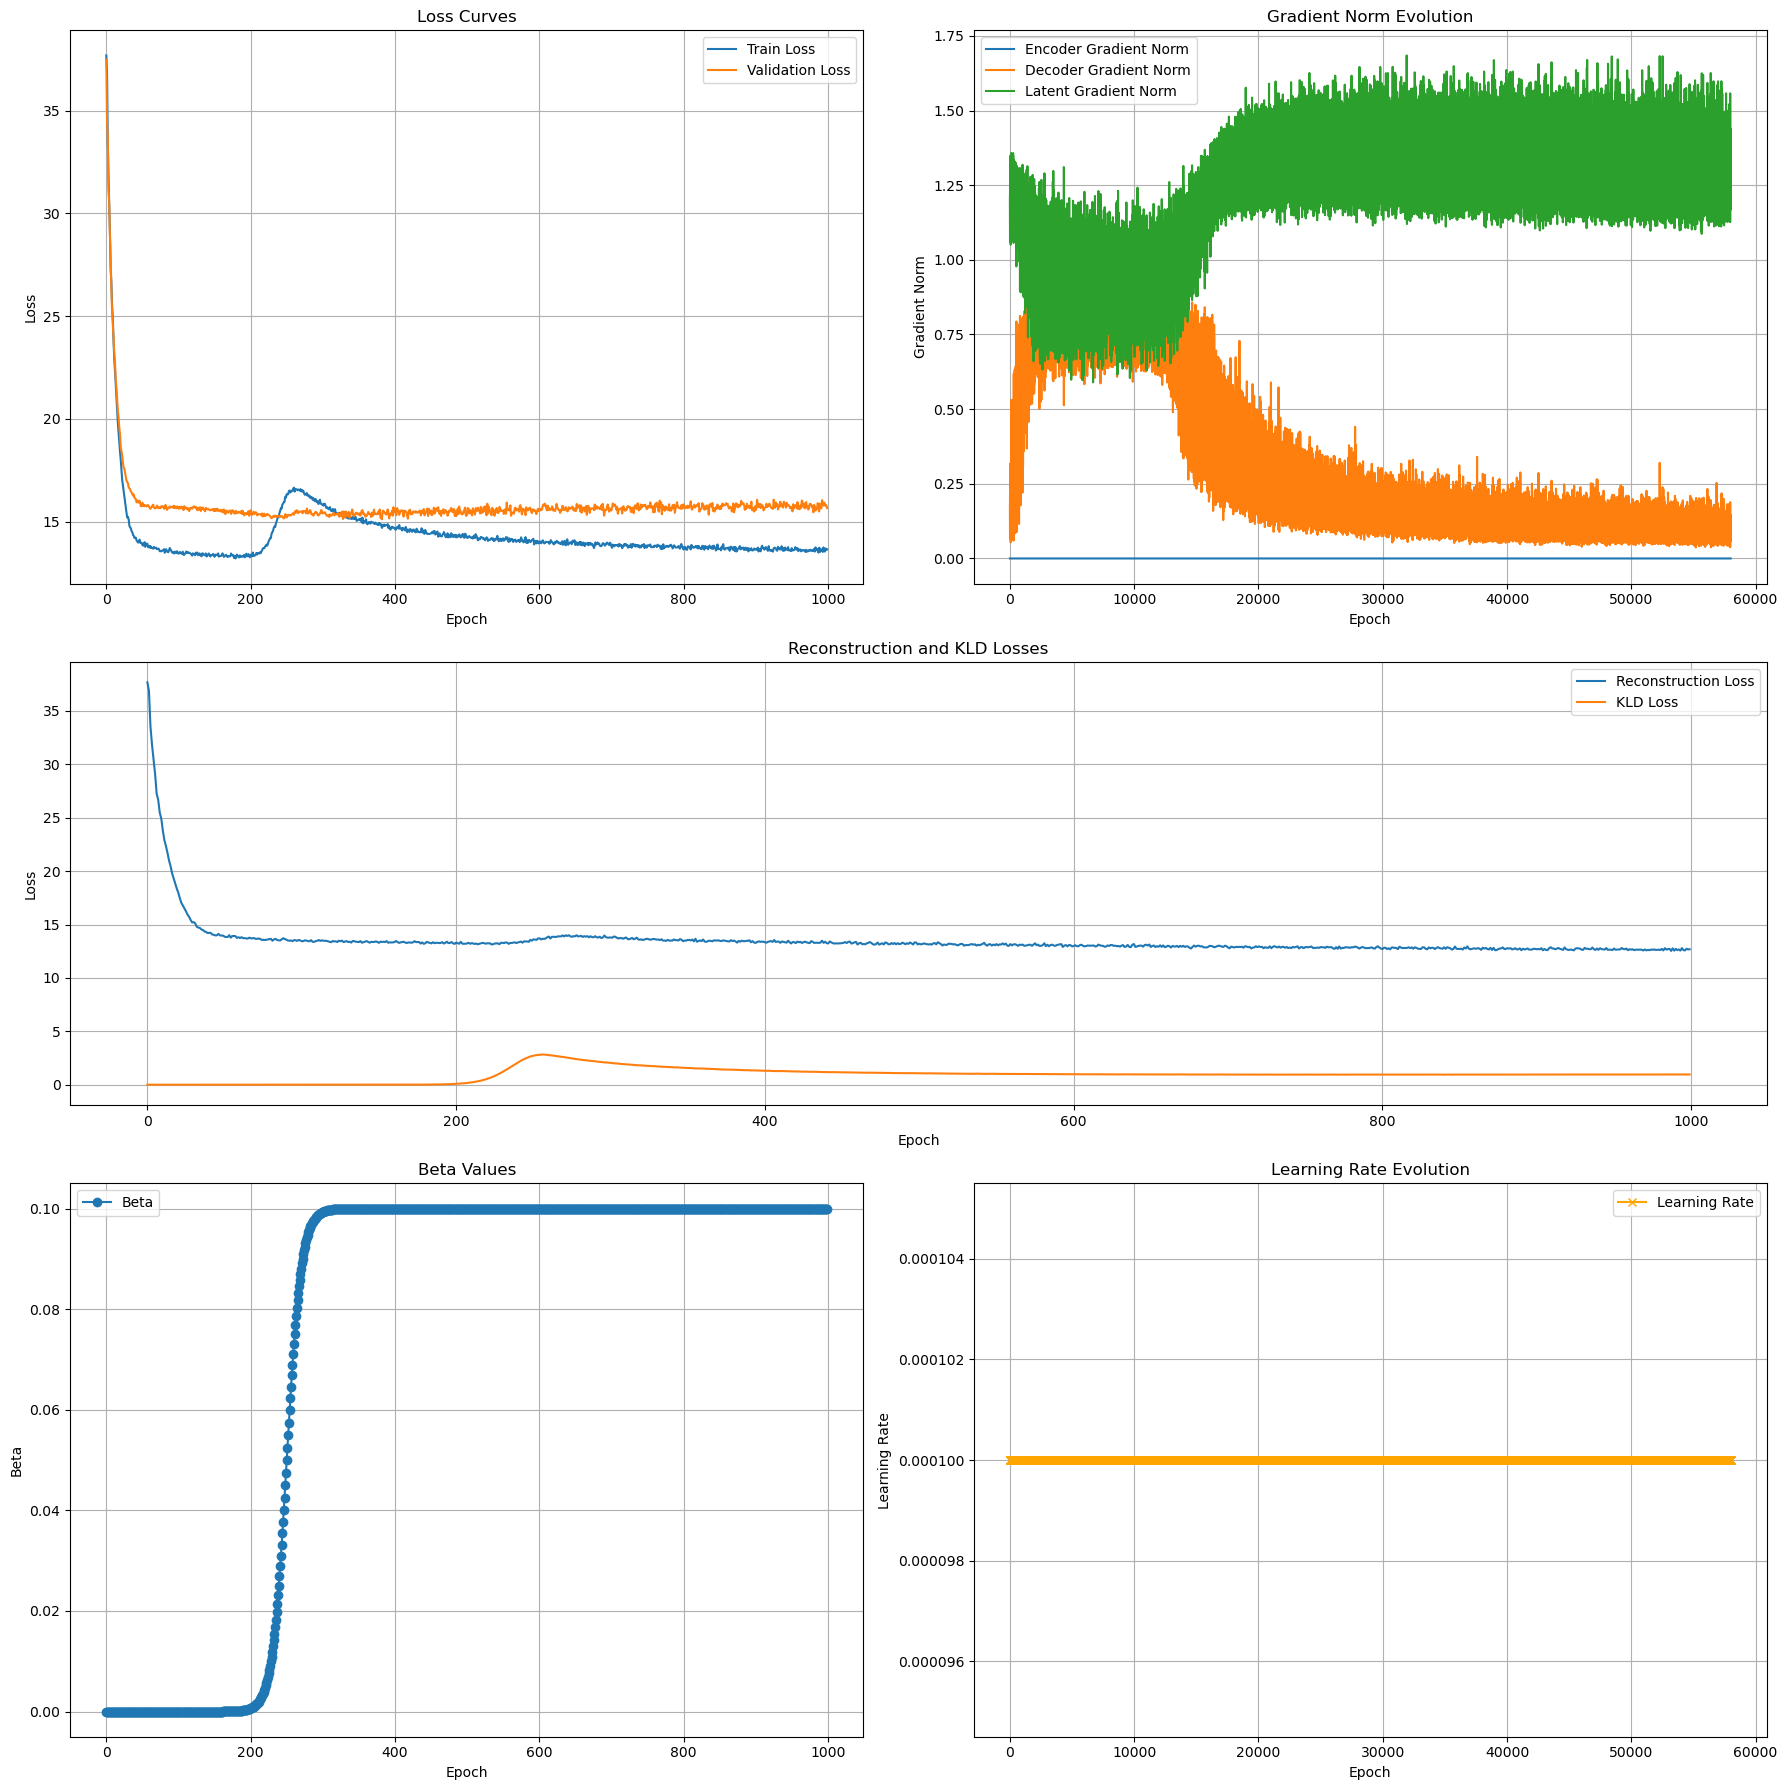

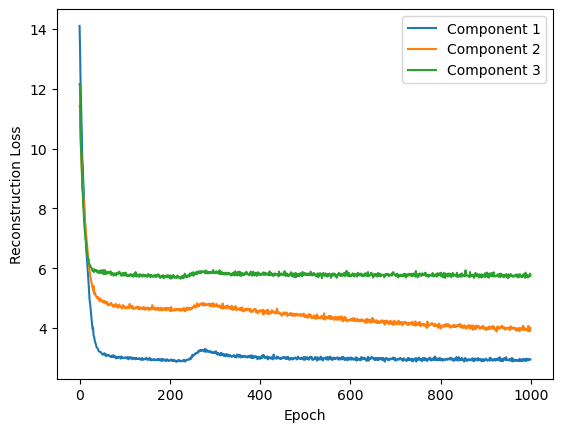

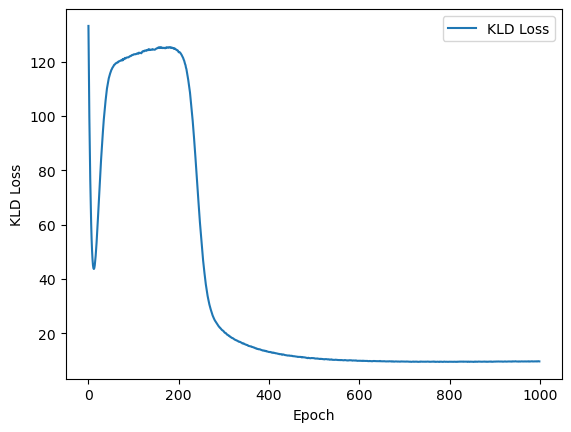

In [39]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.8, 1])

# Row 1: Loss Curves and Gradient Norm Evolution

# Loss Curves (Train and Validation)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

# Gradient Norm Evolution (Encoder, Decoder, Latent)
ax2 = fig.add_subplot(gs[0, 1])
epochs_grad = range(len(gradient_history["encoder"]))
ax2.plot(epochs_grad, gradient_history["encoder"], label="Encoder Gradient Norm")
ax2.plot(epochs_grad, gradient_history["decoder"], label="Decoder Gradient Norm")
ax2.plot(epochs_grad, gradient_history["latent"], label="Latent Gradient Norm")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Gradient Norm")
ax2.set_title("Gradient Norm Evolution")
ax2.legend()
ax2.grid(True)

# Row 2: Reconstruction & KLD Losses (spanning both columns)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(recon_losses, label='Reconstruction Loss')
ax3.plot(effective_kld_losses, label='KLD Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Reconstruction and KLD Losses')
ax3.legend()
ax3.grid(True)

# Row 3: Beta and Learning Rate Evolution

# Beta Values
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(beta_values, label='Beta', marker='o')
ax4.set_title('Beta Values')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Beta')
ax4.legend()
ax4.grid(True)

# Learning Rate Evolution
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(lr_evolution, label='Learning Rate', color='orange', marker='x')
ax5.set_title('Learning Rate Evolution')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Learning Rate')
ax5.legend()
ax5.grid(True)

plt.tight_layout()
plt.show()

array_separate_recon = np.array(separate_recon_losses)

for i in range(n_components):
    plt.plot(array_separate_recon[:, i], label=f'Component {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

plt.plot(kld_losses, label='KLD Loss')
plt.xlabel('Epoch')
plt.ylabel('KLD Loss')
plt.legend()
plt.show()




### Linear model training:

In [40]:
linear_model = one_layer_net(r,output_dim) 

linear_optimizer = optim.Adam(filter(lambda p: p.requires_grad, linear_model.parameters()), lr=decoder_config["learning_rate"])
scheduler_config = decoder_config.get("scheduler")
scheduler = get_scheduler(optimizer, scheduler_config)

linear_train_losses, linear_val_losses, linear_recon_losses, linear_stopped_epoch, linear_lr_evolution, linear_separate_recon_losses = recon_fmri_pclinear(
    device=device,
    epochs=20,
    train_loader=train_loader,
    val_loader=val_loader, 
    r=r,
    n_components=n_components,
    model=linear_model,
    optimizer=linear_optimizer,
    scheduler=scheduler,
    scheduler_config=scheduler_config,
    early_stopping_params=decoder_config["early_stopping"]
)

Epoch [1/20], Rec Loss: 31.7588, , lr = 0.000100
Separate Recon Loss per component: [11.148079677227416, 9.699317757028048, 10.911396047456668]
Epoch [2/20], Rec Loss: 30.7293, , lr = 0.000100
Separate Recon Loss per component: [10.794140791762722, 9.311946130971439, 10.623224318874339]
Epoch [3/20], Rec Loss: 29.8292, , lr = 0.000100
Separate Recon Loss per component: [10.377495570782104, 9.037738529059405, 10.41395855679538]
Epoch [4/20], Rec Loss: 28.9303, , lr = 0.000100
Separate Recon Loss per component: [10.05541983849364, 8.749230715225304, 10.125622658651384]
Epoch [5/20], Rec Loss: 27.9658, , lr = 0.000100
Separate Recon Loss per component: [9.694980817284089, 8.464628901247119, 9.806218523536224]
Epoch [6/20], Rec Loss: 27.1299, , lr = 0.000100
Separate Recon Loss per component: [9.40828004430552, 8.203770129928172, 9.517866282645471]
Epoch [7/20], Rec Loss: 26.4926, , lr = 0.000100
Separate Recon Loss per component: [9.168993556955472, 7.979040727459016, 9.344598705521047]
E

### Saving VAE

In [41]:
# Saving configuration
add_config(decoder_config, model_name, model_database_path)

# Saving the model
save_name = model_name + '.pth'
output_folder = os.path.join('..', 'Def Models')

save_network(
    encoder=encoder,
    decoder=decoder,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    optimizer=optimizer,
    epoch=epochs,
    stopped_epoch=stopped_epoch,
    train_losses=train_losses,
    val_losses=val_losses,
    recon_losses=recon_losses,
    kld_losses=kld_losses,
    effective_kld_losses=effective_kld_losses,
    separate_recon_losses=separate_recon_losses,
    beta_values=beta_values,
    lr_evolution=lr_evolution,
    gradient_history=gradient_history,
    output_folder=output_folder,
    model_name=save_name
)


Model saved to ..\Def Models\Example.pth


### Network's outputs

In [42]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#########################################################################
loader = test_loader
dataset = test_dataset
embedded_matrix = embedded_test_matrix

time_series_start = test_time_start
time_series_end = test_time_end

print('##################################################################')
print('Time series indexes:', time_series_start, time_series_end)
print('Time series sample = ', time_series_end - time_series_start)


decoder_dataset = decoder_dataset[:,:,time_series_start:time_series_end+1]
pupil_signal = pupil_filtered[:,time_series_start:time_series_end+1]
PC_signal = PC_dataset[:,:,time_series_start:time_series_end+1]

print('Decoder dataset shape:', decoder_dataset.shape)
print('Pupil signal shape:', pupil_signal.shape)
print('PC signal shape:', PC_signal.shape)
print('##################################################################')
##########################################################################

inputs, targets, predicted_data, mean_vectors, logvar_vectors = run_model_and_collect_outputs(vae_model, loader, device=device, n_components=n_components, r=r) 
_,linear_predicted_data = run_linear_model_and_collect_outputs(linear_model, loader, device=device, n_components=n_components)
#inputs = dataset.input_data
#targets = dataset.target_data

n_samples = predicted_data.shape[0]


print('Embedded Matrix Shape:', embedded_matrix.shape)


print('##################################################################')
print('type inputs:', type(inputs))
print('type targets:', type(targets))
print('type predicted_data:', type(predicted_data))
print('type linear_predicted_data:', type(linear_predicted_data))
print('###################################################################')


print("Input data shape:", inputs.shape)
print("target data shape (n_sample, n_components, r):" , targets.shape)
print("Linear predicted data shape (n_sample, n_components, r):", linear_predicted_data.shape)
print("VAE Predicted data shape (n_sample, n_components, r):", predicted_data.shape)

print("Mean vectors shape:", mean_vectors.shape)
print("Logvar vectors shape:", logvar_vectors.shape)


print ('#################################################################')

for i in range(n_components):
    linear_mse = mean_squared_error(linear_predicted_data[:,i,:],targets[:,i,:]) 
    vae_mse =mean_squared_error(predicted_data[:,i,:],targets[:,i,:])  
    print('Component ', i+1)
    print(f'Linear Model MSE: {linear_mse:.4f}')
    print(f'VAE Model MSE: {vae_mse:.4f}')

##################################################################
Time series indexes: 740 907
Time series sample =  167
Decoder dataset shape: (3, 21680, 168)
Pupil signal shape: (3, 168)
PC signal shape: (3, 3, 168)
##################################################################
Embedded Matrix Shape: (3, 3, 20, 130)
##################################################################
type inputs: <class 'numpy.ndarray'>
type targets: <class 'numpy.ndarray'>
type predicted_data: <class 'numpy.ndarray'>
type linear_predicted_data: <class 'numpy.ndarray'>
###################################################################
Input data shape: (390, 15)
target data shape (n_sample, n_components, r): (390, 3, 15)
Linear predicted data shape (n_sample, n_components, r): (390, 3, 15)
VAE Predicted data shape (n_sample, n_components, r): (390, 3, 15)
Mean vectors shape: (390, 10)
Logvar vectors shape: (390, 10)
#################################################################
Component  1
Li

In [43]:
# Evaluation of the model between input and output:

for i in range(n_components):

    print('#################################################################')    
    r2_vae = r2_score(targets[:,i,:].flatten(), predicted_data[:,i,:].flatten())
    print("R2 score:", r2_vae)

    r2_linear = r2_score(targets[:,i,:].flatten(), linear_predicted_data[:,i,:].flatten())
    #print("R2 score linear:", r2_linear)

print('#################################################################')

#################################################################
R2 score: 0.7384446859359741
#################################################################
R2 score: 0.4668753147125244
#################################################################
R2 score: 0.1276492476463318
#################################################################


In [ ]:
# Inversione del flatten sui database:
predicted_data = predicted_data.transpose(1,2,0)
linear_predicted_data = linear_predicted_data.transpose(1,2,0)
targets = targets.transpose(1,2,0)
inputs = inputs.T


print('#################################################################')
print("Predicted data shape (n_components, r, n_samples):", predicted_data.shape)
print("Targets shape (n_components, r, n_samples):", targets.shape)
print("Input data shape (r, n_samples):", inputs.shape)
print('#################################################################')

# Reshaper for (n_components, r, range_set, samples_set)

predicted_data = predicted_data.reshape(n_components, r, range_set, -1)
linear_predicted_data = linear_predicted_data.reshape(n_components, r, range_set, -1)
targets = targets.reshape(n_components, r, range_set, -1)
inputs = inputs.reshape(r, range_set, -1)


print('#################################################################')
print("Predicted data shape (n_components, r, range_set, samples_set):", predicted_data.shape)
print("Targets shape (n_components, r, range_set, samples_set):", targets.shape)
print("Input data shape (r, range_set, samples_set):", inputs.shape)
print('#################################################################')

# Transpose the predicted data to (range_set, n_components, r, samples_set)
predicted_data = predicted_data.transpose(2,0,1,3)
linear_predicted_data = linear_predicted_data.transpose(2,0,1,3)
targets = targets.transpose(2,0,1,3)
inputs = inputs.transpose(1,0,2)

test_sample = targets.shape[3]

print('#################################################################')
print("Predicted data shape (range_set, n_components, r, samples_set):", predicted_data.shape)
print("Targets shape (range_set, n_components, r, samples_set):", targets.shape)
print("Input data shape (range_set, r, samples_set):", inputs.shape)
print('#################################################################')


#################################################################
Predicted data shape (n_components, r, n_samples): (3, 15, 390)
Targets shape (n_components, r, n_samples): (3, 15, 390)
Input data shape (r, n_samples): (15, 390)
#################################################################
#################################################################
Predicted data shape (n_components, r, range_set, samples_set): (3, 15, 3, 130)
Targets shape (n_components, r, range_set, samples_set): (3, 15, 3, 130)
Input data shape (r, range_set, samples_set): (15, 3, 130)
#################################################################
#################################################################
Predicted data shape (range_set, n_components, r, samples_set): (3, 3, 15, 130)
Targets shape (range_set, n_components, r, samples_set): (3, 3, 15, 130)
Input data shape (range_set, r, samples_set): (3, 15, 130)
#################################################################


In [ ]:
r2_sets = np.zeros((range_set, n_components, test_sample))
r2_sets_linear = np.zeros((range_set, n_components, test_sample))

for i in range(range_set):
    for j in range(n_components):
        for k in range(test_sample):
            r2_sets[i, j, k] = r2_score(targets[i, j, :, k], predicted_data[i, j, :, k])
            r2_sets_linear[i, j, k] = r2_score(targets[i, j, :, k], linear_predicted_data[i, j, :, k])

for i in range(range_set):

    print('################################################################')
    for j in range(n_components):

        print(f"R2 PC {j+1} rs-fmri-{index[i]} VAE: {np.mean(r2_sets[i, j, :])}")
       # print(f"R2 PC {j+1} set {i+1} linear: {np.mean(r2_sets_linear[i, j, :])}")
    print('################################################################')
        #plt.hist(r2_sets[i, j, :], bins=20)
        #plt.title(f"R2 Component {j+1} Set {i+1}")
        #plt.show()

            

################################################################
R2 PC 1 rs-fmri-2 VAE: 0.6175933461922866
R2 PC 2 rs-fmri-2 VAE: -0.22184271858288693
R2 PC 3 rs-fmri-2 VAE: -0.9908341485720414
################################################################
################################################################
R2 PC 1 rs-fmri-3 VAE: 0.649096712240806
R2 PC 2 rs-fmri-3 VAE: -0.9187429588574629
R2 PC 3 rs-fmri-3 VAE: -2.279122006434661
################################################################
################################################################
R2 PC 1 rs-fmri-4 VAE: -0.006398455454752996
R2 PC 2 rs-fmri-4 VAE: 0.6005540728569031
R2 PC 3 rs-fmri-4 VAE: 0.1930639230287992
################################################################


### Dimensionality recover

In [46]:
# Pseudo-inverse evaluation
P_pseudo_inverse = pinv(P)  


print('targets shape:', targets.shape)

rev_predicted_data = np.zeros((range_set, n_components, embedding_dim, test_sample))
rev_linear_predicted_data = np.zeros((range_set, n_components, embedding_dim, test_sample))
rev_target_data = np.zeros((range_set, n_components, embedding_dim, test_sample))
rev_input_data = np.zeros((range_set, embedding_dim, test_sample))


for i in range(range_set):
    for j in range(n_components):
        rev_predicted_data[i,j,:,:] = np.dot(predicted_data[i,j,:,:].T, P_pseudo_inverse).T
        rev_linear_predicted_data[i,j,:,:] = np.dot(linear_predicted_data[i,j,:,:].T, P_pseudo_inverse).T
        rev_target_data[i,j,:,:] = np.dot(targets[i,j,:,:].T, P_pseudo_inverse).T
    rev_input_data[i,:,:] = np.dot(inputs[i,:,:].T, P_pseudo_inverse).T
print('rev_predicted_data shape:', rev_predicted_data.shape)
print('rev_linear_predicted_data shape:', rev_linear_predicted_data.shape)
print('original data shape:', embedded_matrix.shape)
print('rev_target_data shape:', rev_target_data.shape)
print('rev_input_data shape:', rev_input_data.shape)



# r2 after inversion for dataset:

print('#################################################################')
print(' R2 between target and predicted data after inversion:')
for i in range(range_set):
    for j in range(n_components):
        r2_vae = r2_score(rev_target_data[i,j], rev_predicted_data[i,j])
        r2_linear = r2_score(rev_target_data[i,j], rev_linear_predicted_data[i,j])
        print(f"Dataset {i+1}, PC {j+1} - R2 VAE: {r2_vae:.4f}, R2 Linear: {r2_linear:.4f}")


print('#################################################################')
print(' R2 between target and original embeddings after target inversion:')
for i in range(range_set):
    r2_inversion = r2_score(rev_target_data[i,j], embedded_matrix[i,j])
    print(f"Dataset {i+1}, PC {j+1} - R2 after inversion: {r2_inversion:.4f}")
print('#################################################################')


targets shape: (3, 3, 15, 130)
rev_predicted_data shape: (3, 3, 20, 130)
rev_linear_predicted_data shape: (3, 3, 20, 130)
original data shape: (3, 3, 20, 130)
rev_target_data shape: (3, 3, 20, 130)
rev_input_data shape: (3, 20, 130)
#################################################################
 R2 between target and predicted data after inversion:
Dataset 1, PC 1 - R2 VAE: -3.0395, R2 Linear: -23.6197
Dataset 1, PC 2 - R2 VAE: -0.1111, R2 Linear: -2.4770
Dataset 1, PC 3 - R2 VAE: -1.1299, R2 Linear: -4.8848
Dataset 2, PC 1 - R2 VAE: 0.4329, R2 Linear: -3.7771
Dataset 2, PC 2 - R2 VAE: -1.1989, R2 Linear: -4.4308
Dataset 2, PC 3 - R2 VAE: -5.5012, R2 Linear: -17.1544
Dataset 3, PC 1 - R2 VAE: 0.1624, R2 Linear: -3.3157
Dataset 3, PC 2 - R2 VAE: -0.1370, R2 Linear: -6.7400
Dataset 3, PC 3 - R2 VAE: 0.1126, R2 Linear: -8.9688
#################################################################
 R2 between target and original embeddings after target inversion:
Dataset 1, PC 3 - R2 after i

### Time series reconstruction

n_time_step: 

168


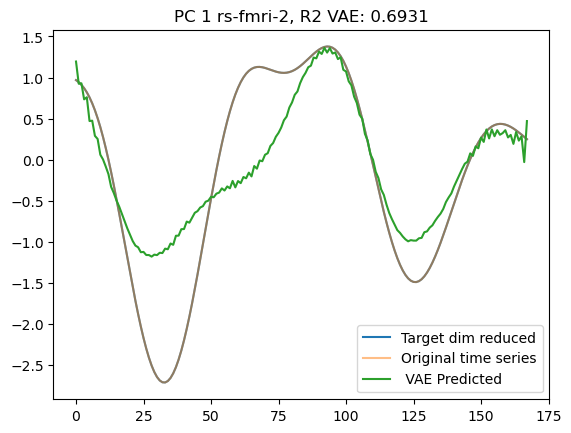

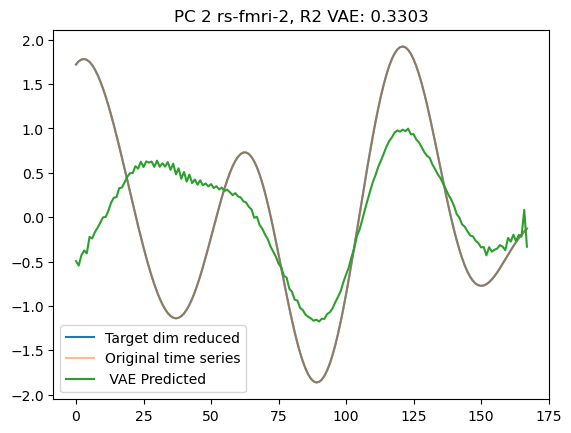

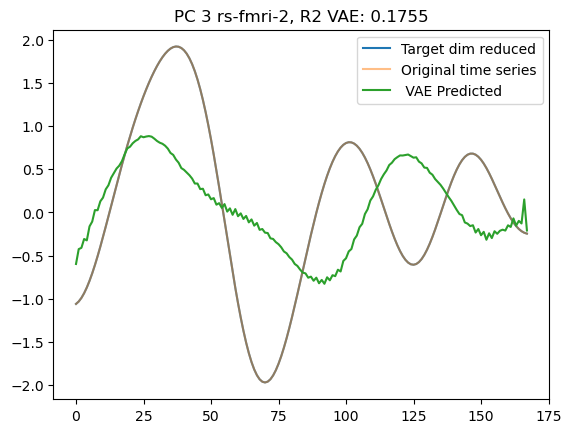

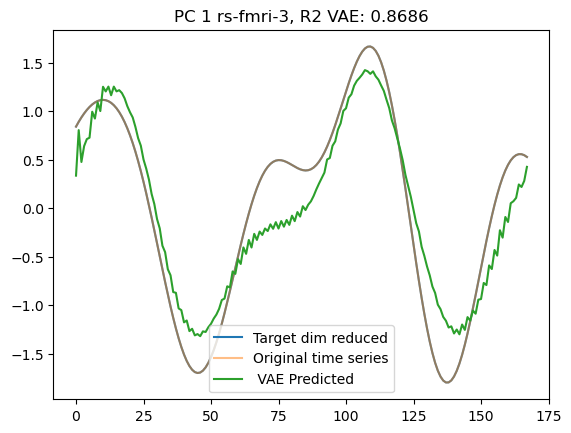

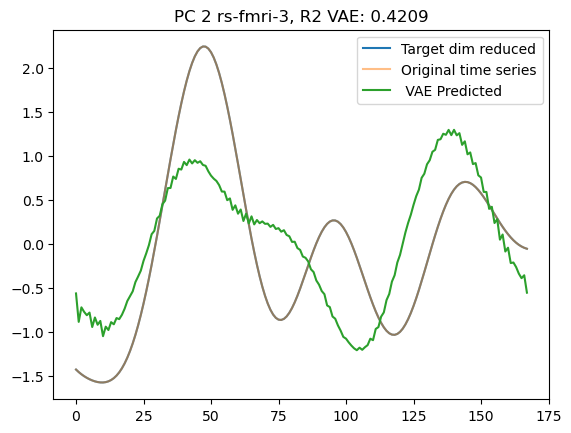

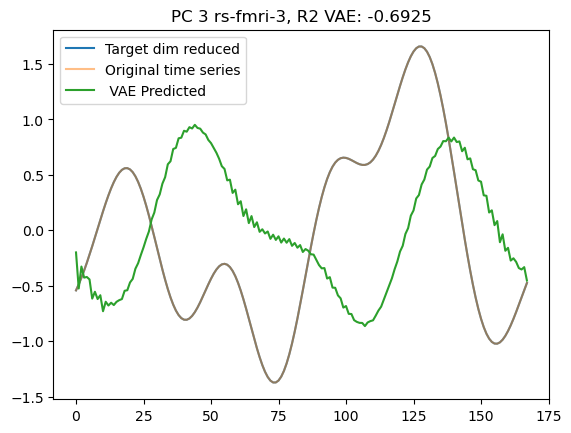

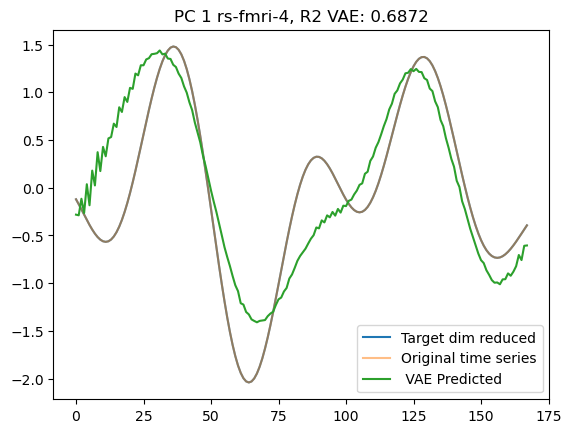

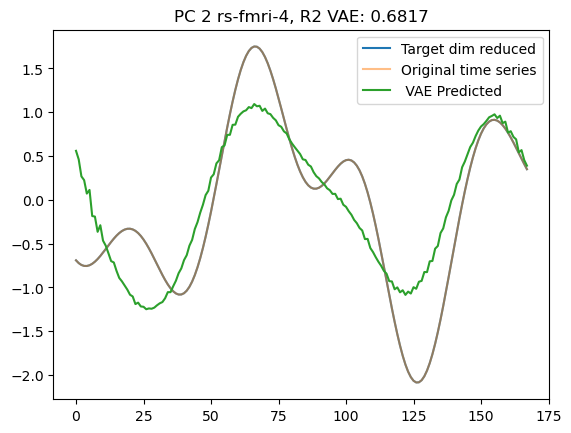

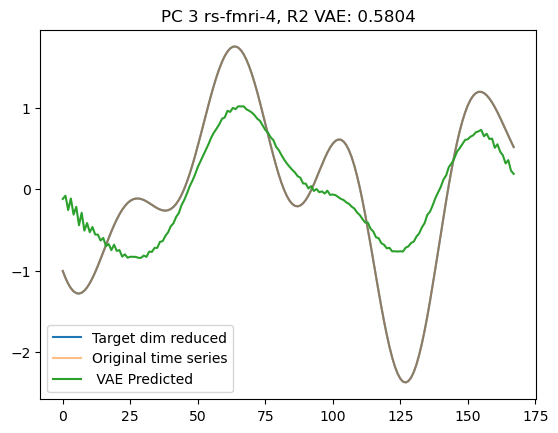

#################################################################
Original pupil shape: (3, 168)
Rev Legendre pupil shape: (3, 168)
Original PC data shape: (3, 3, 168)
Rev Embeddings PC time series shape: (3, 3, 168)
Rev Legendre PC time series shape: (3, 3, 168)
Predicted PC time series shape: (3, 3, 168)
Linear Predicted PC time series shape: (3, 3, 168)
#################################################################


In [ ]:
targets_time_series = reconstruct_signal_from_embedding(rev_target_data[0,0,:,:].T ,embedding_dim=embedding_dim, delay=tau) #Dummy method
n_time_step = np.array(targets_time_series.shape[0])
print('n_time_step:', n_time_step)

targets_time_series = np.zeros((range_set, n_components, n_time_step))
predicted_time_series = np.zeros((range_set, n_components, n_time_step))
linear_predicted_time_series = np.zeros((range_set, n_components, n_time_step))
original_time_series = np.zeros((range_set, n_components, n_time_step))
input_original_time_series = np.zeros((range_set, n_time_step))


for i in range(range_set):
    for j in range(n_components):
        targets_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_target_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        predicted_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_predicted_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        linear_predicted_time_series[i,j,:] = reconstruct_signal_from_embedding(rev_linear_predicted_data[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
        original_time_series[i,j,:] = reconstruct_signal_from_embedding(embedded_matrix[i,j,:,:].T,embedding_dim=embedding_dim, delay=tau)
    input_original_time_series[i,:] = reconstruct_signal_from_embedding(rev_input_data[i,:].T,embedding_dim=embedding_dim, delay=tau)



'''
for i in range(range_set):
    #r2_pupil = r2_score(pupil_signal[i,:], input_original_time_series[i,:])
    plt.plot(input_original_time_series[i,:], label='Rev Pupil')
    plt.plot(pupil_signal[i,:], label='Original Pupil', alpha = 0.5)
    plt.title(f'Pupil dimensionality recovery {i+1}')
    plt.legend()
    plt.show()
'''

for i in range(range_set):
    for j in range(n_components):

        r2_vae = r2_score(original_time_series[i,j,:],predicted_time_series[i,j,:])
        r2_linear = r2_score(original_time_series[i,j,:],linear_predicted_time_series[i,j,:])

        plt.plot(targets_time_series[i,j,:], label='Target dim reduced')
        plt.plot(original_time_series[i,j,:], label='Original time series', alpha = 0.5)
        #plt.plot(PC_signal[i,j,:], label='PC time series from original data', alpha = 0.5) # Check of indexes for time association recovery
        plt.plot(predicted_time_series[i,j,:], label=' VAE Predicted')
        #plt.plot(linear_predicted_time_series[i,j,:], label='Linear Predicted')
        plt.title(f'PC {j+1} rs-fmri-{index[i]}, R2 VAE: {r2_vae:.4f}')
        plt.legend()
        plt.show()

print('#################################################################')
print('Original pupil shape:', pupil_signal.shape)
print('Rev Legendre pupil shape:', input_original_time_series.shape)
print('Original PC data shape:', PC_signal.shape)
print('Rev Embeddings PC time series shape:', original_time_series.shape)
print('Rev Legendre PC time series shape:', targets_time_series.shape)
print('Predicted PC time series shape:', predicted_time_series.shape)
print('Linear Predicted PC time series shape:', linear_predicted_time_series.shape)
print('#################################################################')


            

### PCA inversion

In [ ]:
spatial_shape = (56, 48, 32)

n_voxels = PCA_transformation[0].components_.shape[1]

fmri_functional_data = np.zeros((range_set,56 ,48, 32, n_time_step))
recon_functional_data = np.zeros((range_set,56 ,48, 32, n_time_step))

fmri_dynamics = np.zeros((range_set, active_voxels, n_time_step))
recon_dynamics = np.zeros((range_set, active_voxels, n_time_step))


print('Decoder dataset shape:', decoder_dataset.shape)
original_fmri_data = np.zeros((range_set,56 ,48, 32, n_time_step))

r2_fmri_vae = []

# Invert normalizazion of data:
for i in range(len(PC_dataset)):
    # Extracts the normalized matrix for set i (shape: (n_components, T))
    pc_norm = original_time_series[i]
    pc_recon_norm = predicted_time_series[i]
    n_components, T = pc_norm.shape

    pc_inv = np.empty_like(pc_norm)
    pr_recon_inv = np.empty_like(pc_recon_norm)
    
    # For each component j, it inverts the normalization: x_original = normalized * std + mu
    for j in range(n_components):
        mu, std = norm_params[i][j]
        pc_inv[j] = pc_norm[j] * std + mu
        pr_recon_inv[j] = pc_recon_norm[j] * std + mu  
    
    original_time_series[i] = pc_inv
    predicted_time_series[i] = pr_recon_inv

for i in range(range_set):

    pca_model_i = PCA_transformation[i]
    # Reshape the 1D time-series to 2D with shape (n_time_step, 1) so that inverse_transform works correctly.
    fmri_dynamics[i] = pca_model_i.inverse_transform(original_time_series[i].reshape(-1, n_components)).T
    recon_dynamics[i] = pca_model_i.inverse_transform(predicted_time_series[i].reshape(-1, n_components)).T

    print('PCA dynamics shape:', fmri_dynamics[i].shape)
    print('PCA recon dynamics shape:', recon_dynamics[i].shape)

    r2_inv_trasf = r2_score(fmri_dynamics[i].flatten(), recon_dynamics[i].flatten())
    r2_fmri_vae.append(r2_inv_trasf)
    r2_original = r2_score(fmri_dynamics[i].flatten(), decoder_dataset[i].flatten())
    error = mean_squared_error(fmri_dynamics[i].flatten(), decoder_dataset[i].flatten())
    print(f'R2 score PC1/PC1 recon set {i+1}: ', r2_inv_trasf)
    print(f'R2 score ORIGINAL fmri / PCA inverted recon set {i+1}: ', r2_original)

    # Reconstruct the 4D functional data from the PCA dynamics
    recon_functional_data[i] = invert_functional_data(recon_dynamics[i], active_voxels_indices[i], spatial_shape, n_time_step) # PC1 recon
    fmri_functional_data[i] = invert_functional_data(fmri_dynamics[i], active_voxels_indices[i], spatial_shape, n_time_step) # PC1 original
    original_fmri_data[i] = invert_functional_data(decoder_dataset[i], active_voxels_indices[i], spatial_shape, n_time_step) # No PCA applied

r2_fmri_vae = np.array(r2_fmri_vae)


print('Active voxels shape:' , active_voxels_indices.shape)
print('Fmri functional data shape:', fmri_functional_data.shape)
print('Recon functional data shape:', recon_functional_data.shape)
print('Fmri flatten data shape:', fmri_dynamics.shape)
print('Recon flatten data shape:', recon_dynamics.shape)

Decoder dataset shape: (3, 21680, 168)
PCA dynamics shape: (21680, 168)
PCA recon dynamics shape: (21680, 168)
R2 score PC1/PC1 recon set 1:  0.6530435616130591
R2 score ORIGINAL fmri / PCA inverted recon set 1:  -2.5607450926379425
PCA dynamics shape: (21680, 168)
PCA recon dynamics shape: (21680, 168)
R2 score PC1/PC1 recon set 2:  0.8000637639235055
R2 score ORIGINAL fmri / PCA inverted recon set 2:  -3.7881369617788208
PCA dynamics shape: (21680, 168)
PCA recon dynamics shape: (21680, 168)
R2 score PC1/PC1 recon set 3:  0.6833112176646204
R2 score ORIGINAL fmri / PCA inverted recon set 3:  -5.103738639133789
Active voxels shape: (3, 21680)
Fmri functional data shape: (3, 56, 48, 32, 168)
Recon functional data shape: (3, 56, 48, 32, 168)
Fmri flatten data shape: (3, 21680, 168)
Recon flatten data shape: (3, 21680, 168)


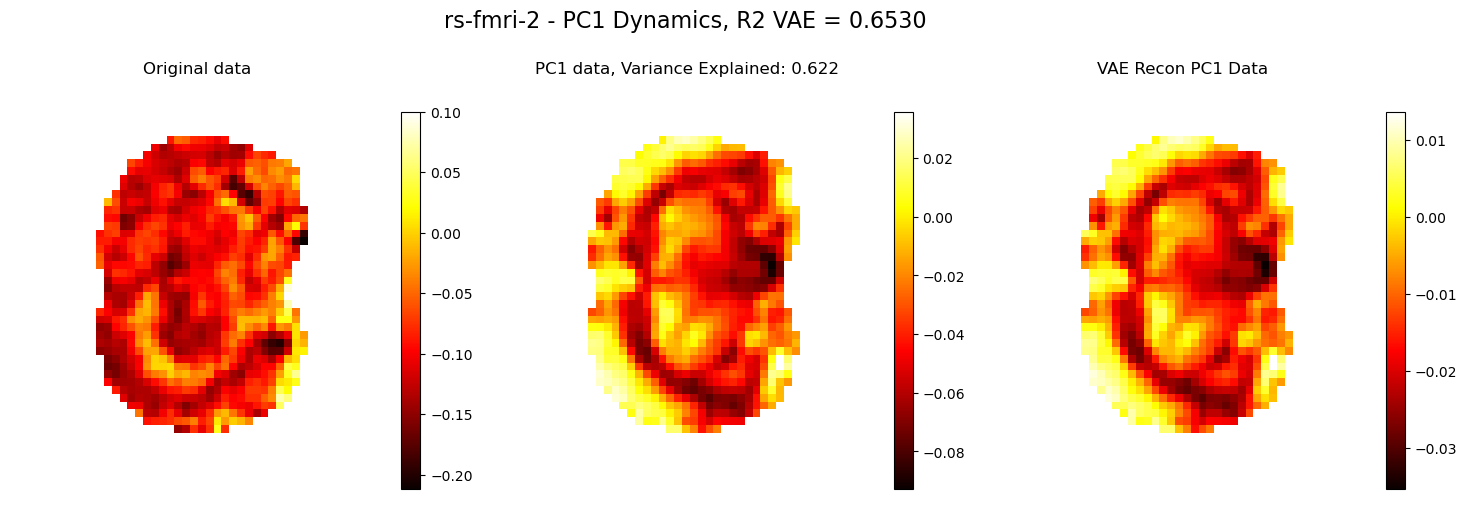

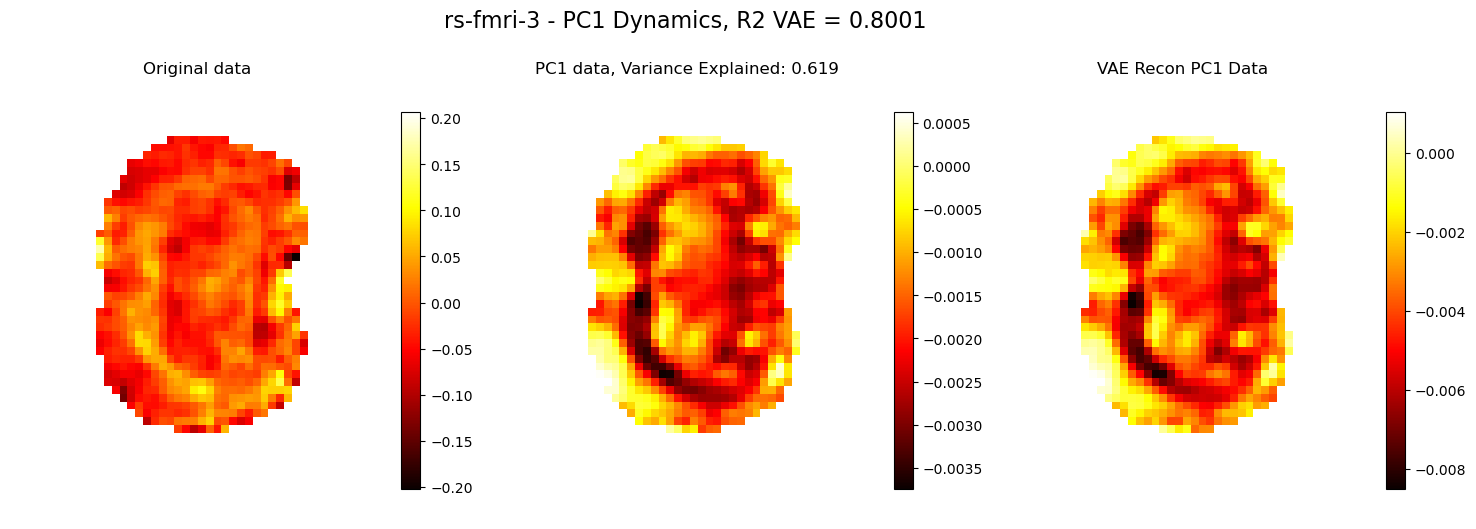

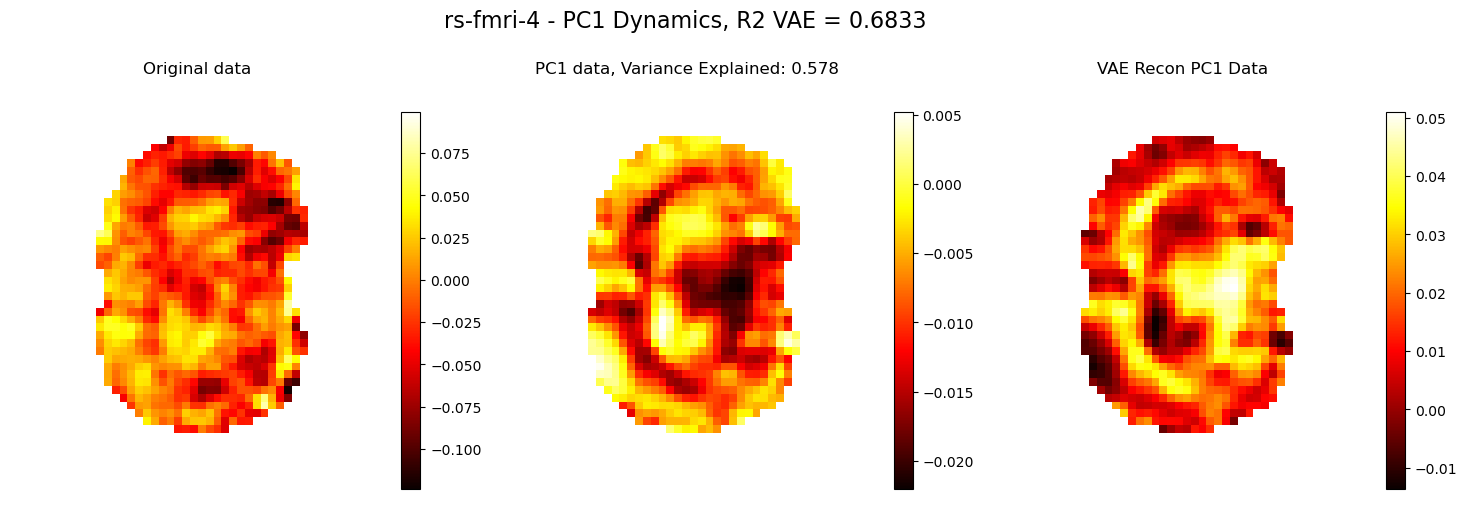

In [51]:
slice = 16
for i in range(range_set):

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    data1 = np.mean(fmri_functional_data[i, :, :, slice, :], axis=-1)
    data2 = np.mean(recon_functional_data[i, :, :, slice, :], axis=-1)
    data3 = np.mean(original_fmri_data[i, :, :, slice, :], axis=-1)

    fig.suptitle(f'rs-fmri-{index[i]} - PC1 Dynamics, R2 VAE = {r2_fmri_vae[i]:.4f}', fontsize=16)

    im0 = axs[0].imshow(data3, cmap='hot')
    axs[0].set_title('Original data')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(data1, cmap='hot')
    axs[1].set_title(f'PC1 data, Variance Explained: {var_explained[i,n_components-1]:.3f} ')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(data2, cmap='hot')
    axs[2].set_title('VAE Recon PC1 Data')
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
